In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import pickleslicer
from stoqcompiler.unitary import *
from stoqcompiler.verification import *

import jaqalpaq
from jaqalpaq.parser import parse_jaqal_string
from jaqalpaq.emulator import run_jaqal_circuit
from jaqalpaq.generator import generate_jaqal_program
from qscout.v1.native_gates import U_R, U_MS, U_Rz

## Define the 6-qubit system parameters

In [2]:
num_system_qubits = 6

qubit_dimension = 2
system_dimension = qubit_dimension ** num_system_qubits
qubits_to_use = [q for q in range(num_system_qubits)]

def qscout_r(max_angle):
    min_value = -max_angle
    max_value = max_angle
    parameters = [ParameterizedUnitaryParameter("Φ", -np.pi, np.pi, is_angle=True),
                  ParameterizedUnitaryParameter("θ", min_value, max_value, is_angle=True)]
    operation_name = "R"
    connectivity = [[q] for q in range(num_system_qubits)]
    allowed_apply_to = [apply_to for apply_to in connectivity if set(apply_to).issubset(set(qubits_to_use))]
    return UnitaryPrimitive(ParameterizedUnitary(qubit_dimension, U_R, parameters, operation_name), allowed_apply_to)

def qscout_rz(max_angle):
    min_value = -max_angle
    max_value = max_angle
    parameters = [ParameterizedUnitaryParameter("θ", min_value, max_value, is_angle=True)]
    operation_name = "Rz"
    connectivity = [[q] for q in range(num_system_qubits)]
    allowed_apply_to = [apply_to for apply_to in connectivity if set(apply_to).issubset(set(qubits_to_use))]
    return UnitaryPrimitive(ParameterizedUnitary(qubit_dimension, U_Rz, parameters, operation_name), allowed_apply_to)

def qscout_ms(max_angle):
    min_value = -max_angle
    max_value = max_angle
    dimension = 2
    parameters = [ParameterizedUnitaryParameter("Φ", -np.pi, np.pi, is_angle=True),
                  ParameterizedUnitaryParameter("θ", min_value, max_value, is_angle=True)]
    operation_name = "MS"
    connectivity = [[i,j] for i in range(num_system_qubits) for j in range(num_system_qubits) if i != j]
    allowed_apply_to = [apply_to for apply_to in connectivity if set(apply_to).issubset(set(qubits_to_use))]
    return UnitaryPrimitive(ParameterizedUnitary(qubit_dimension ** 2, U_MS, parameters, operation_name), allowed_apply_to)

## How RAV uncertainty scales with # of shots

- Choose a representative long-enough random RAV circuit with ideal output state $\lvert\psi\rangle \approx \sqrt{1-\epsilon} \lvert0\rangle + \sqrt{\epsilon} \lvert\textrm{other states}\rangle$
- Plot a whole bunch of points, x-axis = # shots, y-axis = initial state probability, for:
   - 100% ideal output state $2^n \cdot \rho = \lvert\psi\rangle\langle\psi\rvert$
   - 75% ideal output state $2^n \cdot \rho = \frac{3}{4} \lvert\psi\rangle\langle\psi\rvert + \frac{1}{4} I$
   - 50% ideal output state $2^n \cdot \rho = \frac{1}{2} \lvert\psi\rangle\langle\psi\rvert + \frac{1}{2} I$
   - 25% ideal output state $2^n \cdot \rho = \frac{1}{4} \lvert\psi\rangle\langle\psi\rvert + \frac{3}{4} I$
   - completely mixed output state $2^n \cdot \rho = I$

In [3]:
unitary_primitive_counts = {
    qscout_r(max_angle=np.pi/10): 3,
    qscout_rz(max_angle=np.pi/10): 3,
    qscout_ms(max_angle=np.pi/10): 1
}

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
directory = f"output_ideal_rav_vs_xeb_simulations/{timestamp}"
if not os.path.exists(directory):
    os.makedirs(directory)

In [4]:
sequence_count = 5
layer_count = 10

rav_results = []
for seq_idx in range(sequence_count):
    final_cost = 1.0
    while final_cost > 0.05:
        rav_result = Verification.generate_layered_rav_sequence(
            system_dimension,
            unitary_primitive_counts,
            layer_count,
            max_step_count = 5000,
            threshold = 1.0,
        )

        product = rav_result.compiled_sequence.product()
        identity = Unitary.identity(system_dimension)
        final_cost = product.distance_from(identity)

        print(f"generated circuit: length {rav_result.compiled_sequence.get_length()} with final cost {final_cost}")

    rav_results.append(rav_result)
    filename = f'{directory}/rav_{num_system_qubits}q_{layer_count}_{seq_idx}.txt'
    with open(filename, 'w') as f:
        f.write(f'''
    from qscout.v1.std usepulses *
    register q[{len(qubits_to_use)}]
    prepare_all
    ''')
        f.write(rav_result.compiled_sequence.get_jaqal())
        f.write(f'''
    measure_all
    ''')

    print(f"SUCCESS: wrote JAQAL circuit to {filename}")

generated circuit: length 84 with final cost 0.0830705764880908
generated circuit: length 161 with final cost 0.053889519657718266
generated circuit: length 105 with final cost 0.05912467264498
generated circuit: length 98 with final cost 0.04232713350881556
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220418_094437/rav_6q_10_0.txt
generated circuit: length 112 with final cost 0.0573189087813023
generated circuit: length 119 with final cost 0.0837803022126713
generated circuit: length 112 with final cost 0.06637471318388433
generated circuit: length 119 with final cost 0.06269914423680711
generated circuit: length 112 with final cost 0.059515263106890925
generated circuit: length 126 with final cost 0.040905790493005134
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220418_094437/rav_6q_10_1.txt
generated circuit: length 133 with final cost 0.062066793110015506
generated circuit: length 133 with final cost 0.07930342748819907
generated ci

In [5]:
rav_x_data = {}
rav_y_data = {}    
for seq_idx, rav_result in enumerate(rav_results):
    rav_sequence_matrix = rav_result.compiled_sequence.product().get_matrix()

    mixed_state_fraction_list = [0.0, 0.25, 0.5, 0.75, 1.0]

    rav_x_data[seq_idx] = {}
    rav_y_data[seq_idx] = {}

    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        initial_state_index = 1

        # calculate the ideal output state
        initial_state = np.zeros(system_dimension)
        initial_state[initial_state_index] = 1
        initial_state = np.atleast_2d(initial_state).T
        ideal_output_state = rav_sequence_matrix @ initial_state
        #print("ideal_output_state coefficients:", np.round(ideal_output_state.T, 4))

        # validate the state
        ideal_output_probs = np.array([np.linalg.norm(c)**2 for c in ideal_output_state])
        #print("ideal_output_probs =", np.round(ideal_output_probs, 4))
        sum_of_probs = np.sum([np.linalg.norm(c)**2 for c in ideal_output_state])
        assert np.isclose(sum_of_probs, 1.0)

        # mix in the mixed state fraction
        mixed_state_output_probs = np.array([1/system_dimension for _ in range(system_dimension)])
        output_probs = np.add(
            (1-mixed_state_fraction) * ideal_output_probs,
            mixed_state_fraction * mixed_state_output_probs
        )
        print(f"mixed_state_fraction = {mixed_state_fraction}, output_probs = {np.round(output_probs, 4)}")

        # sample many times and plot
        n_shots_list = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]
        repetitions = 100
        rav_x_data[seq_idx][mixed_state_fraction] = []
        rav_y_data[seq_idx][mixed_state_fraction] = []
        for n_shots in n_shots_list:
            for _ in range(repetitions):
                measurements = [int(np.random.random() < output_probs[initial_state_index]) for _ in range(n_shots)]
                scaled_fidelity = (np.mean(measurements) - 1/system_dimension) * (system_dimension/(system_dimension-1))

                rav_x_data[seq_idx][mixed_state_fraction].append(n_shots)
                rav_y_data[seq_idx][mixed_state_fraction].append(scaled_fidelity)

mixed_state_fraction = 0.0, output_probs = [1.500e-03 9.151e-01 1.580e-02 3.000e-03 0.000e+00 1.400e-03 0.000e+00
 0.000e+00 1.000e-04 1.840e-02 3.000e-04 1.800e-03 0.000e+00 5.100e-03
 1.000e-04 0.000e+00 3.000e-03 2.300e-03 2.000e-04 1.080e-02 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e-04 1.000e-04 0.000e+00 2.000e-04
 0.000e+00 0.000e+00 0.000e+00 1.000e-04 0.000e+00 2.400e-03 0.000e+00
 0.000e+00 0.000e+00 1.560e-02 3.000e-04 1.000e-04 0.000e+00 1.400e-03
 0.000e+00 0.000e+00 0.000e+00 3.000e-04 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e-04 0.000e+00 0.000e+00 2.000e-04
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00]
mixed_state_fraction = 0.25, output_probs = [0.005  0.6903 0.0157 0.0061 0.0039 0.005  0.0039 0.0039 0.0039 0.0177
 0.0041 0.0053 0.0039 0.0078 0.004  0.0039 0.0061 0.0057 0.0041 0.012
 0.0039 0.0039 0.0039 0.0039 0.004  0.004  0.0039 0.004  0.0039 0.0039
 0.0039 0.004  0.0039 0.0057 0.0039 0.0039 0.0039 

mixed_state_fraction = 0.25, output_probs = [0.005  0.6818 0.0131 0.0042 0.0041 0.0062 0.0039 0.0048 0.0056 0.0085
 0.004  0.004  0.0039 0.0044 0.0039 0.0039 0.0078 0.0095 0.004  0.0042
 0.0039 0.0099 0.004  0.004  0.0041 0.032  0.0044 0.0042 0.0039 0.0041
 0.0039 0.004  0.0039 0.0062 0.004  0.0068 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.004  0.0039 0.004
 0.0039 0.0039 0.0039 0.0039]
mixed_state_fraction = 0.5, output_probs = [0.0085 0.4597 0.0139 0.008  0.008  0.0094 0.0078 0.0084 0.0089 0.0109
 0.0079 0.0079 0.0078 0.0081 0.0078 0.0078 0.0104 0.0115 0.0079 0.008
 0.0078 0.0118 0.0079 0.0079 0.0079 0.0266 0.0081 0.008  0.0078 0.008
 0.0078 0.0079 0.0078 0.0093 0.0078 0.0097 0.0078 0.0078 0.0078 0.0078
 0.0078 0.0078 0.0078 0.0078 0.0078 0.0078 0.0078 0.0078 0.0078 0.0078
 0.0078 0.0078 0.0078 0.0078 0.0078 0.0078 0.0078 0.0079 0.0078 0.0079
 0.0078 0.0078 0.0078 0.0078]
mixe

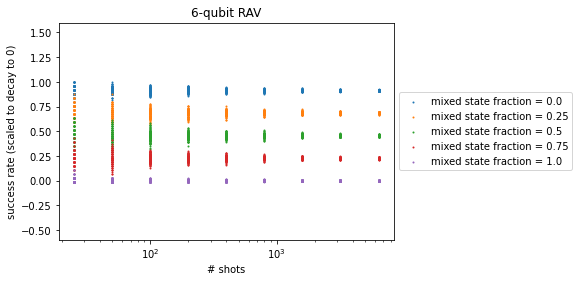

In [6]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    plt.scatter(
        rav_x_data[0][mixed_state_fraction],
        rav_y_data[0][mixed_state_fraction],
        s=1, label=f'mixed state fraction = {mixed_state_fraction}')
    
plt.ylim(-0.6, 1.6)
plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('success rate (scaled to decay to 0)')
plt.title(f'{num_system_qubits}-qubit RAV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [7]:
rav_std_data = {}
for seq_idx, rav_result in enumerate(rav_results):
    rav_std_data[seq_idx] = {}
    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        rav_std_data[seq_idx][mixed_state_fraction] = []    
        for n_shots in n_shots_list:
            current_slice = np.array(rav_x_data[seq_idx][mixed_state_fraction]) == n_shots
            y_vals = np.extract(current_slice, rav_y_data[seq_idx][mixed_state_fraction])
            rav_std_data[seq_idx][mixed_state_fraction].append(np.std(y_vals))

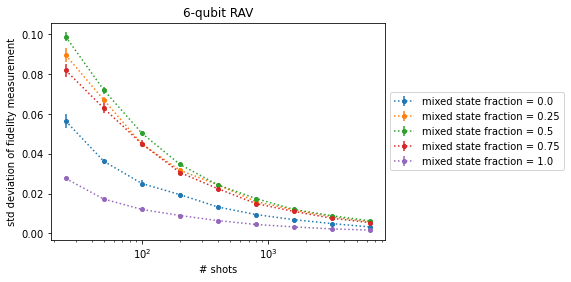

In [8]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    y_raw = [rav_std_data[seq_idx][mixed_state_fraction] for seq_idx in rav_std_data]
    plt.errorbar(
        n_shots_list,
        y=np.mean(y_raw, axis=0),
        yerr=np.std(y_raw, axis=0) / np.sqrt(sequence_count),
        marker='.',
        markersize=8, label=f'mixed state fraction = {mixed_state_fraction}',
        linestyle='dotted')

plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('std deviation of fidelity measurement')
plt.title(f'{num_system_qubits}-qubit RAV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## How XEB uncertainty scales with # of shots

- Choose a representative random circuit of same length used above for RAV with ideal output state $\lvert\phi\rangle$
- Plot a whole bunch of points, x-axis = # shots, y-axis = initial state probability, for:
   - 100% ideal output state $2^n \cdot \rho = \lvert\phi\rangle\langle\phi\rvert$
   - 75% ideal output state $2^n \cdot \rho = \frac{3}{4} \lvert\phi\rangle\langle\phi\rvert + \frac{1}{4} I$
   - 50% ideal output state $2^n \cdot \rho = \frac{1}{2} \lvert\phi\rangle\langle\phi\rvert + \frac{1}{2} I$
   - 25% ideal output state $2^n \cdot \rho = \frac{1}{4} \lvert\phi\rangle\langle\phi\rvert + \frac{3}{4} I$
   - completely mixed output state $2^n \cdot \rho = I$

In [9]:
xeb_results = []
for seq_idx in range(sequence_count):
    xeb_layer_count = rav_results[seq_idx].compiled_sequence.get_length() // int(sum(list(unitary_primitive_counts.values())))

    xeb_result = Verification.generate_layered_rav_sequence(
        system_dimension,
        unitary_primitive_counts,
        xeb_layer_count,
        max_step_count = 0,
        threshold = 0.0,
    )

    product = xeb_result.compiled_sequence.product()
    identity = Unitary.identity(system_dimension)
    final_cost = product.distance_from(identity)

    print(f"generated XEB circuit: length {xeb_result.compiled_sequence.get_length()} with final cost {final_cost}")

    xeb_results.append(xeb_result)

    filename = f'{directory}/xeb_{num_system_qubits}q_{xeb_layer_count}_{seq_idx}.txt'
    with open(filename, 'w') as f:
        f.write(f'''
    from qscout.v1.std usepulses *
    register q[{len(qubits_to_use)}]
    prepare_all
    ''')
        f.write(xeb_result.compiled_sequence.get_jaqal())
        f.write(f'''
    measure_all
    ''')

    print(f"SUCCESS: wrote JAQAL circuit to {filename}")

generated XEB circuit: length 98 with final cost 0.21631570333503447
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220418_094437/xeb_6q_14_0.txt
generated XEB circuit: length 126 with final cost 0.6194109936519651
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220418_094437/xeb_6q_18_1.txt
generated XEB circuit: length 147 with final cost 0.42275009642581374
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220418_094437/xeb_6q_21_2.txt
generated XEB circuit: length 147 with final cost 0.48384427834433763
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220418_094437/xeb_6q_21_3.txt
generated XEB circuit: length 133 with final cost 0.4398736802595683
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220418_094437/xeb_6q_19_4.txt


In [10]:
xeb_x_data = {}
xeb_y_data = {}    
for seq_idx, xeb_result in enumerate(xeb_results):
    xeb_sequence_matrix = xeb_result.compiled_sequence.product().get_matrix()

    mixed_state_fraction_list = [0.0, 0.25, 0.5, 0.75, 1.0]

    xeb_x_data[seq_idx] = {}
    xeb_y_data[seq_idx] = {}

    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        initial_state_index = 1

        # calculate the ideal output state
        initial_state = np.zeros(system_dimension)
        initial_state[initial_state_index] = 1
        initial_state = np.atleast_2d(initial_state).T
        ideal_output_state = xeb_sequence_matrix @ initial_state
        #print("ideal_output_state coefficients:", np.round(ideal_output_state.T, 4))

        # validate the state
        ideal_output_probs = np.array([np.linalg.norm(c)**2 for c in ideal_output_state])
        #print("ideal_output_probs =", np.round(ideal_output_probs, 4))
        sum_of_probs = np.sum([np.linalg.norm(c)**2 for c in ideal_output_state])
        assert np.isclose(sum_of_probs, 1.0)

        # mix in the mixed state fraction
        mixed_state_output_probs = np.array([1/system_dimension for _ in range(system_dimension)])
        output_probs = np.add(
            (1-mixed_state_fraction) * ideal_output_probs,
            mixed_state_fraction * mixed_state_output_probs
        )
        print(f"mixed_state_fraction = {mixed_state_fraction}, output_probs = {np.round(output_probs, 4)}")

        # sample many times and plot
        n_shots_list = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]
        repetitions = 100
        xeb_x_data[seq_idx][mixed_state_fraction] = []
        xeb_y_data[seq_idx][mixed_state_fraction] = []
        for n_shots in n_shots_list:
            for _ in range(repetitions):
                measurements = [int(np.random.random() < output_probs[initial_state_index]) for _ in range(n_shots)]
                measurements = np.random.choice(system_dimension, size=n_shots, p=output_probs)
                measurement_probs = [np.count_nonzero(measurements == k) / n_shots for k in range(system_dimension)]
                assert np.isclose(np.sum(measurement_probs), 1.0)

                # calculate cross-entropy fidelity between ideal_output_probs, measurement_probs
                e_u = np.sum(ideal_output_probs**2)
                u_u = np.sum(ideal_output_probs) / system_dimension
                m_u = np.sum(ideal_output_probs * measurement_probs)
                y = m_u - u_u
                x = e_u - u_u
                fidelity = (x * y) / (x ** 2)

                xeb_x_data[seq_idx][mixed_state_fraction].append(n_shots)
                xeb_y_data[seq_idx][mixed_state_fraction].append(fidelity)

mixed_state_fraction = 0.0, output_probs = [2.800e-02 7.627e-01 4.300e-03 1.340e-02 4.900e-03 1.200e-02 1.000e-03
 1.970e-02 4.760e-02 2.400e-02 3.300e-03 2.400e-02 8.000e-04 3.000e-04
 2.000e-03 6.000e-04 2.000e-04 5.600e-03 0.000e+00 1.000e-04 0.000e+00
 1.000e-04 0.000e+00 1.000e-04 4.000e-04 5.000e-04 0.000e+00 2.000e-04
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.020e-02 2.320e-02 1.000e-04
 5.800e-03 5.000e-04 4.000e-04 1.000e-04 7.000e-04 2.000e-04 9.000e-04
 2.000e-04 1.300e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e-04
 2.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00]
mixed_state_fraction = 0.25, output_probs = [0.0249 0.5759 0.0072 0.0139 0.0076 0.0129 0.0047 0.0187 0.0396 0.0219
 0.0064 0.0219 0.0045 0.0042 0.0054 0.0044 0.004  0.0081 0.0039 0.004
 0.0039 0.004  0.0039 0.004  0.0042 0.0043 0.0039 0.004  0.0039 0.0039
 0.0039 0.0039 0.0116 0.0213 0.0039 0.0083 0.0043 

mixed_state_fraction = 0.25, output_probs = [0.0472 0.4715 0.0054 0.0236 0.0043 0.0429 0.004  0.006  0.0164 0.0469
 0.0049 0.0048 0.0055 0.011  0.004  0.0041 0.0094 0.0104 0.0042 0.0119
 0.0047 0.0112 0.004  0.0052 0.0055 0.005  0.0041 0.0044 0.0044 0.0049
 0.004  0.004  0.0147 0.0284 0.0039 0.0145 0.0056 0.006  0.004  0.0052
 0.0079 0.0169 0.004  0.0044 0.004  0.0056 0.0039 0.0041 0.0055 0.0041
 0.0044 0.0047 0.004  0.004  0.004  0.0043 0.004  0.0043 0.004  0.004
 0.0039 0.0042 0.0039 0.0039]
mixed_state_fraction = 0.5, output_probs = [0.0366 0.3195 0.0088 0.021  0.0081 0.0338 0.0079 0.0092 0.0162 0.0365
 0.0085 0.0084 0.0089 0.0125 0.0078 0.0079 0.0115 0.0121 0.008  0.0131
 0.0083 0.0127 0.0078 0.0087 0.0088 0.0085 0.0079 0.0081 0.0081 0.0085
 0.0078 0.0079 0.015  0.0242 0.0078 0.0149 0.0089 0.0092 0.0079 0.0087
 0.0105 0.0165 0.0079 0.0082 0.0078 0.009  0.0078 0.0079 0.0089 0.0079
 0.0082 0.0084 0.0079 0.0079 0.0079 0.008  0.0078 0.0081 0.0079 0.0079
 0.0078 0.008  0.0078 0.0078]
mi

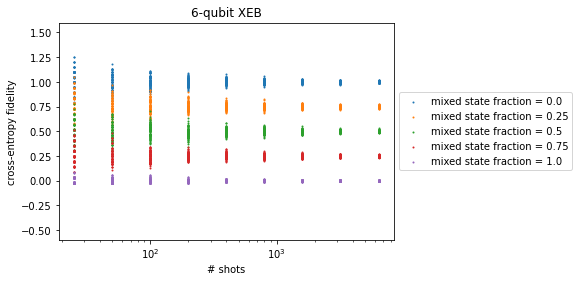

In [11]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    plt.scatter(
        xeb_x_data[0][mixed_state_fraction],
        xeb_y_data[0][mixed_state_fraction],
        s=1, label=f'mixed state fraction = {mixed_state_fraction}')

plt.ylim(-0.6, 1.6)
plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('cross-entropy fidelity')
plt.title(f'{num_system_qubits}-qubit XEB')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
xeb_std_data = {}
for seq_idx, xeb_result in enumerate(xeb_results):
    xeb_std_data[seq_idx] = {}
    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        xeb_std_data[seq_idx][mixed_state_fraction] = []    
        for n_shots in n_shots_list:
            current_slice = np.array(xeb_x_data[seq_idx][mixed_state_fraction]) == n_shots
            y_vals = np.extract(current_slice, xeb_y_data[seq_idx][mixed_state_fraction])
            xeb_std_data[seq_idx][mixed_state_fraction].append(np.std(y_vals))

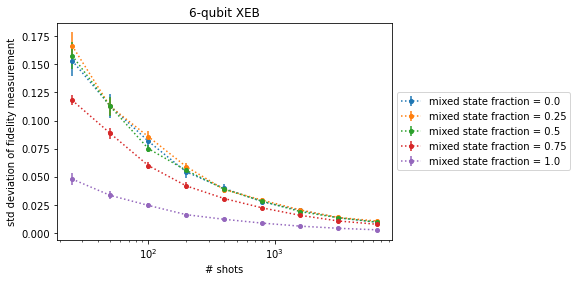

In [13]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    y_raw = [xeb_std_data[seq_idx][mixed_state_fraction] for seq_idx in xeb_std_data]
    plt.errorbar(
        n_shots_list,
        y=np.mean(y_raw, axis=0),
        yerr=np.std(y_raw, axis=0) / np.sqrt(sequence_count),
        marker='.',
        markersize=8, label=f'mixed state fraction = {mixed_state_fraction}',
        linestyle='dotted')

plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('std deviation of fidelity measurement')
plt.title(f'{num_system_qubits}-qubit XEB')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [14]:
save_data = {
    "mixed_state_fraction_list": mixed_state_fraction_list,
    "n_shots_list": n_shots_list,
    "rav_x_data": rav_x_data,
    "rav_y_data": rav_y_data,
    "rav_std_data": rav_std_data,
    "xeb_x_data": xeb_x_data,
    "xeb_y_data": xeb_y_data,
    "xeb_std_data": xeb_std_data,
}
pickleslicer.dump(save_data, f'{directory}/ideal_rav_vs_xeb_simulations_{num_system_qubits}q.pickle')
print(f'Saved to {directory}/ideal_rav_vs_xeb_simulations_{num_system_qubits}q.pickle')

Saved to output_ideal_rav_vs_xeb_simulations/20220418_094437/ideal_rav_vs_xeb_simulations_6q.pickle


In [16]:
directory = 'output_ideal_rav_vs_xeb_simulations/20220418_094437'
load_data = pickleslicer.load(f'{directory}/ideal_rav_vs_xeb_simulations_{num_system_qubits}q.pickle')
mixed_state_fraction_list = load_data["mixed_state_fraction_list"]
n_shots_list = load_data["n_shots_list"]
rav_x_data = load_data["rav_x_data"]
rav_y_data = load_data["rav_y_data"]
rav_std_data = load_data["rav_std_data"]
xeb_x_data = load_data["xeb_x_data"]
xeb_y_data = load_data["xeb_y_data"]
xeb_std_data = load_data["xeb_std_data"]